In [1]:
import os
import sys
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from demo_utils.kiro_udp_send import start_mobile_udp_thread, send_pose_wait, get_xyzw_cur, get_reach_state
from pkg.utils.utils import *    
ip_cur =  get_ip_address()
MOBILE_IP = "192.168.0.102"
print("Current PC IP: {}".format(ip_cur))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.4
Mobile ROB IP: 192.168.0.102


In [3]:
sock, server_thread = start_mobile_udp_thread(recv_ip=ip_cur)

In [4]:
# Directory setting
DEMO_DIR = os.path.join(RNB_PLANNING_DIR, "src/scripts/demo_202107")
CONFIG_DIR = os.path.join(DEMO_DIR, "configs")
SAVE_DIR = os.path.join(DEMO_DIR, "save_img")
CROP_DIR = os.path.join(DEMO_DIR, "crop_img")
MODEL_DIR = os.path.join(DEMO_DIR, "model_CAD")

# Table dimension
T_Width = 1.8
T_Height = 0.785
T_Depth = 0.734

In [5]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
INDY_IP = "192.168.0.3"
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7, None,
                INDY_IP, specs={"no_sdk":True})]
              , connection_list=[False])

connection command:
indy0: False


In [6]:
from pkg.geometry.builder.scene_builder import SceneBuilder
s_builder = SceneBuilder(None)
# s_builder.reset_reference_coord(ref_name="floor")

In [7]:
# xyz_rpy_robots = s_builder.detect_items(level_mask=[DetectionLevel.ROBOT])
xyz_rpy_robots = {"indy0": ((0,0,0), (0,0,np.pi))}
crob.update_robot_pos_dict(xyz_rpy_robots=xyz_rpy_robots)
gscene = s_builder.create_gscene(crob)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]


In [8]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


In [9]:
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.set_workspace_boundary( -1.5, 1.5, -1, 1, -0.1, 1.75)

 * Environment: production
Please create a subscriber to the marker
   Use a production WSGI server instead.
 * Debug mode: off


## add env

In [10]:

# geometry 추가
mobile_base = gscene.create_safe(gtype=GEOTYPE.BOX, name="mobile_base", link_name="base_link", 
                   dims=(0.6,0.4,0.439), center=(0,0,-0.439/2), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)
floor = gscene.create_safe(gtype=GEOTYPE.BOX, name="floor", link_name="base_link", 
                   dims=(10,10,0.01), center=(0,0,-0.439), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## add cam

In [11]:
for gtem in gscene:
    round_it_str(gtem.dims)
    round_it_str(gtem.center)

In [12]:
from pkg.geometry.geotype import GEOTYPE
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name="indy0_tcp", 
                   dims=(0.061,0.061,0.026), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name="indy0_tcp", 
                   dims=(0.081,0.081,0.046), center=(-0.0785,0,0.013), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name="indy0_tcp", 
                   dims=(0.01,0.01,0.01), center=(0,0,0), rpy=(0,0,-np.pi/2), 
                   color=(1,0,0,0.3), display=True, fixed=True, collision=False, parent="cam")

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.0335), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.0535), center=(-0.0785,0,-0.01675), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name="indy0_tcp", 
                   dims=(0.067,0.067,0.067), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False)

gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name="indy0_tcp", 
                   dims=(0.087,0.087,0.087), center=(-0.0785,0,-0.0335), rpy=(0,0,0), 
                   color=(0.0,1,0,0.3), display=True, fixed=True, collision=True)

In [13]:
gscene.update_markers_all()

## add indy tool

In [14]:
gscene = gscene
robot_name="indy0"
face_name="brush_face"

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.09, 0.09, 0.005), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_adapter_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0025), dims=(0.13, 0.13, 0.005), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.022, 0.036, 0.025), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge0_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0, 0, 0.0125), dims=(0.062, 0.076, 0.025), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.011, 0.020, 0.15), rpy=(0, 1*pi/4, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_bar_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.053, 0, 0.068), dims=(0.051, 0.060, 0.15), rpy=(0, 1*pi/4, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.036, 0.022), rpy=(0, 0, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_hindge1_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1085,0,0.121), dims=(0.025, 0.076, 0.062), rpy=(0, 0, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1285,0,0.121), dims=(0.08, 0.08, 0.015), rpy=(0, pi/2, 0), color=(0.8, 0.8, 0.8, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="{}_brushbase_col".format(robot_name),
                   link_name="{}_tcp".format(robot_name),
                   center=(0.1285,0,0.121), dims=(0.12, 0.12, 0.015), rpy=(0, pi/2, 0), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name=face_name, link_name="{}_tcp".format(robot_name),
                   center=(0.147,0,0.121), dims=(0.037, 0.10, 0.34), rpy=(np.pi, 0, pi), color=(1.0, 1.0, 0.94, 1),
                   collision=False, fixed=True)
gscene.create_safe(gtype=GEOTYPE.BOX, name="{}_col".format(face_name), link_name="{}_tcp".format(robot_name),
                   center=(0.127,0,0.121), dims=(0.057, 0.10, 0.36), rpy=(np.pi, 0, pi), color=(0.0, 0.8, 0.0, 0.5),
                   collision=True, fixed=True)

## Register binders

In [15]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
pscene.create_binder(bname="brush_face", gname="brush_face", _type=SweepFramer, point=(-gscene.NAME_DICT['brush_face'].dims[0]/2,0,0), 
                     rpy=(0,np.pi/2*1,0))

## Set planner

In [16]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)
mplan.update_gscene()
from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)

from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
from pkg.planning.filtering.latticized_filter import LatticedChecker
from pkg.planning.filtering.task_clearance_filter import TaskClearanceChecker

gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)
tcheck = TaskClearanceChecker(pscene, gcheck)
checkers_all = [tcheck, rcheck, gcheck]
# lcheck = LatticedChecker(pscene, gcheck)
# checkers_all.append(lcheck)

mplan.motion_filters = checkers_all

## move indy to viewing pose

In [17]:
indy = crob.robot_dict["indy0"]

In [18]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., 179.])
if indy is not None:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(Qcur)

In [19]:
viewpoint.draw_traj_coords([Qcur])

[array([[ 7.09853221e-03, -4.06674659e-01,  9.13545473e-01,
          3.34360899e-01],
        [-9.99847710e-01, -1.74524058e-02,  1.63322856e-11,
          1.87870006e-01],
        [ 1.59435663e-02, -9.13406350e-01, -4.06736601e-01,
          8.61128940e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [20]:
from demo_utils.streaming import *
HOST = '192.168.0.4'

In [21]:
rdict = send_recv_demo_cam({1:1}, host=HOST)

In [22]:
rdict = stream_capture_image(ImageType.FirstView, host=HOST)
cam_intrins, d_scale = [rdict[key] for key in ["intrins", "depth_scale"]]


== press s to save image ==


In [23]:
import SharedArray as sa
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

IMG_URI = "shm://color_img"
MASK_URI = "shm://mask_img"
REQ_URI = "shm://request"
RESP_URI = "shm://response"

color_img_p = sa.attach(IMG_URI)
return_img_p = sa.attach(MASK_URI)
request_p = sa.attach(REQ_URI)
resp_p = sa.attach(RESP_URI)

def detect_from_server(image):
    color_img_p[:] = image[:]
    request_p[:] = 1
    while not resp_p[0]:
        time.sleep(0.01)
    resp_p[:] = 0
    return np.copy(return_img_p.astype(np.bool))

In [24]:
# Set color, depth image path
if indy is None:
    color_img_path = DATASET_DIR + '/color.jpg'
    depth_img_path = DATASET_DIR + '/depth.png'
else:
    color_img_path = SAVE_DIR + '/color.jpg'
    depth_img_path = SAVE_DIR + '/depth.png'

# Read color, depth image file, keep 16bit information
color_img_read = cv2.imread(color_img_path, flags=cv2.IMREAD_UNCHANGED)
depth_img_read = cv2.imread(depth_img_path, flags=cv2.IMREAD_UNCHANGED)

In [25]:
# Output of inference(mask for detected table)
mask_out = detect_from_server(color_img_read)

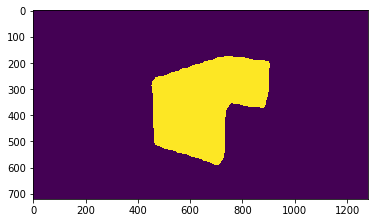

In [26]:
plt.imshow(mask_out)

In [27]:
# Crop masking part
vis_mask = (mask_out * 255).astype('uint8')
color_instance = cv2.bitwise_and(color_img_read, color_img_read, mask=vis_mask).astype(np.uint16)
depth_instance = cv2.bitwise_and(depth_img_read, depth_img_read, mask=vis_mask).astype(np.uint16)
cv2.imwrite(CROP_DIR + '/color_crop.jpg', color_instance)
cv2.imwrite(CROP_DIR + '/depth_crop.png', depth_instance)

True

In [28]:
from demo_utils.detect_table import *

In [29]:
set_cam_params(cam_intrins, d_scale)
model_mesh, pcd_out = preprocessing()
ICP_result1 = compute_ICP(model_mesh, pcd_out, (-T_Height, -T_Depth, 0.0))
#ICP_result2 = compute_ICP(model_mesh, pcd2)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=6.561198e-03, and correspondence_set size of 36119
Access transformation to get result.
Transformation is:
[[ 0.8826282  -0.0104582   0.46995542 -0.52440395]
 [ 0.19101167  0.92147256 -0.33823494 -0.23628738]
 [-0.42951369  0.38830266  0.8153153   2.35653982]
 [ 0.          0.          0.          1.        ]]


In [30]:
VIEW_POSE = np.deg2rad([  0., -28.,  85.,  -0.,  57., 179.])
gscene.show_pose(VIEW_POSE)
viewpoint.draw_traj_coords([VIEW_POSE])

[array([[ 7.09853221e-03, -4.06674659e-01,  9.13545473e-01,
          3.34360899e-01],
        [-9.99847710e-01, -1.74524058e-02,  1.63322856e-11,
          1.87870006e-01],
        [ 1.59435663e-02, -9.13406350e-01, -4.06736601e-01,
          8.61128940e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])]

In [31]:
from pkg.utils.rotation_utils import *
TABLE_DIMS = np.array((0.785,1.80,0.735))
OFF_DIR = np.array([1,1,-1])
# OFF_DIR = np.array([1,1,0])
#TABLE_DIMS[[0,1,2]]
#np.hstack([TABLE_DIMS[[0,1]], [0]])
T_toff = SE3(Rot_axis(3,np.pi), np.divide(TABLE_DIMS[[0,1,2]]*OFF_DIR,2))
T_co = np.matmul(np.matmul(ICP_result1, SE3(Rot_axis(1, np.pi/2), [0]*3)), T_toff)
T_lo = np.matmul(viewpoint.Toff, T_co)
T_bc = viewpoint.get_tf(list2dict(VIEW_POSE, gscene.joint_names))
T_bo=np.matmul(T_bc, T_co)

In [32]:
# fit to plane
floor_g = gscene.NAME_DICT["floor"]
floor_height = floor_g.center[2] + floor_g.dims[2]/2

## Floor Fitting
# T_bo[2,3] =  + TABLE_DIMS[2]/2

# Depth scaling
T_bfcenter = SE3(np.identity(3), [0,0,floor_height+TABLE_DIMS[2]/2])
T_fc = np.matmul(SE3_inv(T_bfcenter), T_bc)
T_fo = np.matmul(SE3_inv(T_bfcenter), T_bo)
dz_cam = T_fc[2,3]
dz_obj = -T_fo[2,3]
dz_co = dz_cam + dz_obj
depth_newscale = dz_cam/dz_co
T_co_new = T_co.copy()
T_co_new[:3,3] *= depth_newscale
T_bo_new = np.matmul(T_bc, T_co_new)
T_co = T_co_new
T_bo = T_bo_new

azimuth, zenith = mat2hori(T_bo[:3,:3])
zenith_up = np.pi-zenith
Raz = Rot_axis(3, azimuth)
Rzn = Rot_axis(2, -zenith_up)
Roff = np.matmul(np.matmul(Raz, Rzn), Raz.transpose())
T_bo[:3,:3] = np.matmul(Roff, T_bo[:3,:3])

gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry 추가
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

# Table size

In [33]:
TABLE_X, TABLE_Y = TABLE_DIMS[:2]
TABLE_HEIGHT = 0.3
TABLE_DEPTH = 1
TABLE_WIDTH = 1
TOOL_DIM = [0.32, 0.08]

## select task area

In [36]:
from demo_utils.area_select import *

In [41]:
corner_center, area_width, area_depth, height_goal, num_width, num_depth = \
    select_area(TABLE_HEIGHT, TABLE_DEPTH, TABLE_WIDTH)

0.25
0.3


## Add table on relative target location

In [42]:
from demo_utils.area_select import *

In [43]:
for i_cn in range(4):
    cn_cur = CornerRev[i_cn]
    raise(NotImplementedError("copy loop to here"))

NotImplementedError: copy loop to here

In [44]:
cn_cur = CornerRev[1]
print("== Current workspace section: {}".format(cn_cur.name))

== Current workspace section: FrontRight


In [48]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (area_depth,area_width,0.01), 
                           tuple(corner_center)+(height_goal,), rpy=(0,0,0), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

In [49]:
t_corner = np.divide(table.dims, 2)
f_corner = np.divide(track.dims, 2)

In [50]:
T_tc = SE3(corner_orientations[cn_cur], t_corner*corner_point_dirs[cn_cur])
T_fc = SE3(corner_orientations[cn_cur], f_corner*corner_point_dirs[cn_cur])
T_ft = np.matmul(T_fc, SE3_inv(T_tc))
T_bf = track.Toff
T_bt = np.matmul(T_bf, T_ft)
T_tb = SE3_inv(T_bt)

In [51]:
## 6 DoF pose to go
T_bb2 = np.matmul(table.Toff, T_tb)
gscene.add_highlight_axis("target", "base", "base_link", T_bb2[:3,3], T_bb2[:3,:3])

In [52]:
T_mb = SE3(np.identity(3), [0.172, 0, 0.439])

In [53]:
T_bm = SE3_inv(T_mb)
T_mm2 = np.matmul(SE3_inv(T_bm), np.matmul(T_bb2, SE3_inv(T_mb)))
T_bm2 = np.matmul(T_bm, T_mm2)
gscene.add_highlight_axis("target", "mobile", "base_link", T_bm2[:3,3], T_bm2[:3,:3])

In [54]:
gscene.clear_highlight()

In [55]:
# get_relative mobile pose
xy_rel = T_mm2[:2,3]
quat_rel = Rotation.from_dcm(T_mm2[:3, :3]).as_quat()
quat_zw_rel = quat_rel[-2:]
xyzw_rel = np.concatenate([xy_rel, quat_zw_rel])

In [56]:
tar_xyzw = (0,0,0,0)
raise(NotImplementedError("tar_xyzw: relative? absolute?"))
cur_xyzw = send_pose_wait(tar_xyzw, send_ip=MOBILE_IP)

NotImplementedError: tar_xyzw: relative? absolute?

In [58]:
## add moved table in front of robot
table_front = gscene.create_safe(GEOTYPE.BOX, "table_front", "base_link", 
                                 dims=table.dims, 
                                 center=T_bt[:3,3], 
                                 rpy=Rot2rpy(T_bt[:3,:3]),
                                 color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True)

table.color = (0.8,0.8,0.8,0.0)
gscene.update_markers_all()

corner_center_rel = np.abs(np.subtract(tuple(corner_center)+(height_goal,), table_front.center))

### calc gaze pose

In [59]:
if indy is not None:
    with indy:
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE

In [60]:
GAZE_DIST = 0.5

T_bc = np.matmul(T_bt, T_tc)

T_cam_c = SE3(Rot_rpy((0,-np.pi*3/4,np.pi/2)) , (0,0,GAZE_DIST))
T_bcam = np.matmul(T_bc, SE3_inv(T_cam_c))
T_ecam = viewpoint.Toff
T_be = np.matmul(T_bcam, SE3_inv(T_ecam))
gscene.add_highlight_axis("cam", "effector", "base_link", T_be[:3, 3], T_be[:3,:3])
gase_traj, success = mplan.planner.plan_py("indy0", "indy0_tcp", np.concatenate(T2xyzquat(T_be)), "base_link", Qcur)

print("GAZE: {}".format(success))
if success:
    gscene.show_motion(gase_traj)
    gase_pose = gase_traj[-1]

GAZE: True


## Move to gaze pose

In [61]:
if indy is not None:
    indy.move_joint_wp(gase_traj, None, None, None)

## Refine plane

In [62]:
# 모서리부분 근접 촬영
rdict = stream_capture_image(ImageType.CloseView, host=HOST)
set_cam_params(rdict['intrins'], rdict['depth_scale'])

== press s to save image ==


In [63]:
if indy is None:
    img_path = DATASET_DIR + "/table_11.png"
else:
    img_path = SAVE_DIR + '/table.png'

Coeffs of eq of fitting plane are :
(0.18237189136581713, 0.6201844303615793, 0.7629624929029852, -0.4941851292590168)
0.4238755789908296
0.4238755789908296
0.4238755789908296
0.4238755789908296


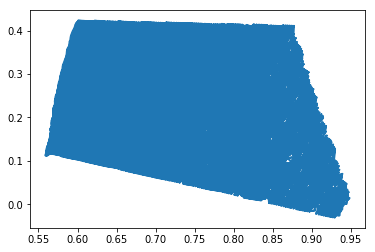

In [71]:
p_inliers = get_inliers(img_path)

Qcur = np.load(DATASET_DIR + '/tablepose_11.npy')
T_bc = viewpoint.get_tf(list2dict(Qcur, gscene.joint_names))
viewpoint.draw_traj_coords([Qcur])
x_bo, y_bo = point_proj(T_bc, p_inliers)

from pkg.utils.rotation_utils import *
if cn_cur in [Corners.BackLeft, Corners.FrontLeft]:
    T_bo = left_corner(x_bo, y_bo)
elif cn_cur in [Corners.BackRight, Corners.FrontRight]:
    T_bo = right_corner(x_bo, y_bo)

TABLE_DIMS = np.array((0.785,1.80,0.735))
TABLE_DIMS[[0,1,2]]
gscene.add_highlight_axis("table", "center", link_name="base_link", center=T_bo[:3,3], orientation_mat=T_bo[:3,:3])

# geometry
table = gscene.create_safe(gtype=GEOTYPE.BOX, name="table_front", link_name="base_link", 
                   dims=TABLE_DIMS, center=T_bo[:3,3], rpy=Rot2rpy(T_bo[:3,:3]), 
                   color=(0.8,0.8,0.8,0.5), display=True, fixed=True, collision=False)

## move track

In [72]:
from pkg.geometry.geotype import GEOTYPE
track = gscene.create_safe(GEOTYPE.BOX, "track", "base_link", (area_depth,area_width,0.01), 
                           corner_center_rel*corner_point_dirs[cn_cur], 
                           rpy=Rot2rpy(corner_orientations[cn_cur]), 
                           color=(0.8,0.8,0.8,0.8), display=True, fixed=True, collision=True,
                           parent="table_front")
track_face = gscene.copy_from(track, new_name="track_face", collision=False, color=(0.8,0.8,0.8,0.2))
TRACK_DIM = np.copy(track_face.dims)
track_face.dims = (3, 3, track.dims[2])
gscene.update_markers_all()

## make work plane

In [73]:
from pkg.planning.task.custom_rules.coverage import *

TOOL_DIM = [0.32, 0.08]
TACK_WIDTH = 0.36
TRACK_NUM = np.ceil(np.divide(TRACK_DIM[0]-TOOL_DIM[0], TOOL_DIM[0])).astype(np.int)+1
TRACK_STEP = TRACK_DIM[0]/TRACK_NUM

img = grayscale("scripts/demo_202107/input.jpg")

table_X = TRACK_DIM[0]
table_Y = TRACK_DIM[1]
table_x = img.shape[0]
table_y = img.shape[1]

path_gap_real = TRACK_STEP
path_gap_img = int(path_gap_real * (table_x / table_X))
wp1_pos_img, wp2_pos_img = make_waypoint(img, path_gap_img)

wp1_pos_real = np.empty([TRACK_NUM,3])
wp1_pos_real[:,0] = wp1_pos_img[:,0] * (table_X / table_x)
wp1_pos_real[:,1] = wp1_pos_img[:,1] * (table_Y / table_y)
wp1_pos_real[:,1] = -wp1_pos_real[:,1];
wp1_pos_real[:,2] = 0

wp2_pos_real = np.empty([TRACK_NUM,3])
wp2_pos_real[:,0] = wp2_pos_img[:,0] * (table_X / table_x)
wp2_pos_real[:,1] = wp2_pos_img[:,1] * (table_Y / table_y)
wp2_pos_real[:,1] = -wp2_pos_real[:,1];
wp2_pos_real[:,2] = 0

wp1_pos_real[:,0] -= TRACK_DIM[0]/2
wp1_pos_real[:,1] +=  TRACK_DIM[1]/2
wp2_pos_real[:,0] -= TRACK_DIM[0]/2
wp2_pos_real[:,1] += TRACK_DIM[1]/2

In [74]:
from pkg.planning.constraint.constraint_actor import Gripper2Tool, PlacePlane, SweepFramer, FixtureSlot
from pkg.planning.constraint.constraint_common import MotionConstraint
from pkg.planning.constraint.constraint_subject import AbstractTask, AbstractObject
from pkg.planning.constraint.constraint_subject import SweepLineTask
from pkg.planning.constraint.constraint_subject import SweepFrame

pscene.create_binder(bname="track_face", gname="track_face", _type=PlacePlane, point=None)

TRC_THIC = TRACK_DIM[2]
track_list = []

wp1_pos_real[:,1] -= TOOL_DIM[1]/2
wp2_pos_real[:,1] += TOOL_DIM[1]/2

for i_trc in range(TRACK_NUM):
    wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp1_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
#     wp1 = gscene.create_safe(GEOTYPE.BOX, "wp{}a".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
#                              (0.4, -0.01, height_goal), rpy=(0,0,0), 
#                              color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False)
    wp2 = gscene.create_safe(GEOTYPE.BOX, "wp{}b".format(i_trc+1), "base_link", (TOOL_DIM[0]/2,TOOL_DIM[1]/2,TRC_THIC), 
                             wp2_pos_real[i_trc,:], rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    
    face = gscene.create_safe(GEOTYPE.BOX, "face{}".format(i_trc+1), "base_link", 
                              (TACK_WIDTH,TRACK_DIM[1],TRC_THIC), 
                             center=(wp1_pos_real[i_trc,:]+wp2_pos_real[i_trc,:])/2,rpy=(0,0,0), 
                             color=(0.8,0.2,0.2,0.2), display=True, fixed=True, collision=False, parent="track_face")
    track_list.append((wp1, wp2, face))
gscene.update_markers_all()

for sname in pscene.subject_name_list:
    pscene.remove_subject(sname)
    
sweep_list = []
for i_t, track_tem in enumerate(track_list):
    wp1, wp2, face = track_tem
    sweep_ = pscene.create_subject(oname="sweep{}".format(i_t+1), gname="track_face", _type=SweepLineTask, 
                                   action_points_dict = {wp1.name: SweepFrame(wp1.name, wp1, [0,0,0.005], [0,0,0]),
                                                       wp2.name: SweepFrame(wp2.name, wp2, [0,0,0.005], [0,0,0])}, 
                                   clearance=[face])
    sweep_list.append(sweep_)

In [75]:
HOME_POSE = [0]*6

In [76]:
from pkg.planning.constraint.constraint_common \
            import sample_redundancy, combine_redundancy
gtimer = GlobalTimer.instance()
# initial_state = pscene.initialize_state(crob.home_pose)
initial_state = pscene.initialize_state([0]*6)
print(initial_state.node)

# # remove place points except for the current one
# use_current_place_point_only(pscene, initial_state)

(0, 0)


In [76]:
from pkg.utils.traj_utils import simplify_schedule, mix_schedule
mplan.reset_log(False)
gtimer.reset()
tplan.prepare()
mplan.update_gscene()
    
print(initial_state.node)

gtimer.tic("firstmove")
obj_num = 0
sweep_num = len(sweep_list)
from_state = initial_state
t_exe = None
snode_schedule_all = []
for sweep_idx in range(sweep_num):
    gcheck.put_banned = [track_list[sweep_idx][2]]
    sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(sweep_num)])
#     sweep_goal = tuple([int(i_s<=sweep_idx)*2 for i_s in range(2)])+(0,)
    goal_nodes = [("track_face",)*obj_num+sweep_goal]
    if sweep_idx < sweep_num-1:
        for i_s in range(obj_num):
            obj_goal = ["track_face"]*obj_num
            obj_goal[i_s] = "grip1"
            goal_nodes += [tuple(obj_goal)+sweep_goal]
    gtimer.tic("plan{}".format(sweep_idx))
    ppline.search(from_state, goal_nodes, verbose=True, display=False, dt_vis=0.01, 
                  timeout_loop=10, multiprocess=True, timeout=1, timeout_constrained=2, add_homing=True, post_optimize=False)
    gtimer.toc("plan{}".format(sweep_idx))
    schedules = ppline.tplan.find_schedules(False)
    schedules_sorted = ppline.tplan.sort_schedule(schedules)
    snode_schedule = ppline.tplan.idxSchedule2SnodeScedule(schedules_sorted[0])
    snode_schedule_ori = snode_schedule
    snode_schedule_simple = simplify_schedule(pscene, snode_schedule)
    snode_schedule_safe = calculate_safe_schedule(pscene, snode_schedule_simple, 5, 1)
#     double_sweep_motions(snode_schedule_safe)
#     snode_schedule = snode_schedule_safe
    snode_schedule = mix_schedule(mplan, snode_schedule_safe)
    from_state = snode_schedule[-1].state
    if t_exe:
        t_exe.join()
    else:
        if len(snode_schedule_all)==0:
            gtimer.toc("firstmove")
    snode_schedule_all.append(snode_schedule)
#     t_exe = Thread(target=ppline.play_schedule, args = (snode_schedule,), kwargs=dict( period=0.01))
#     t_exe.start()
# t_exe.join()

(0, 0)
Use 36/36 agents
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(1, 0)
try: 0 - (0, 0)->(1, 0)
try transition motion
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(0, 1)
try transition motion
try transition motion
try: 0 - (0, 0)->(1, 0)
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
try transition motion
try: 1 - (1, 0)->(2, 0)
transition motion tried: True
transition motion tried: True
branching: 0->1 (0.13/10.0 s, steps/err: 41(62.8850460052 ms)/0.00136100452411)
result: 0 - (0, 0)->(1, 0) = success
try: 2 - (1, 0)->(2, 0)
branching: 0->2 (0.13/10.0 s, steps/err: 41(75.7608413696 ms)/0.00136100452411)
result: 0 - (0, 0)->(1, 0) = success
try: 3 - (1, 0)->(2, 0)
try constrained motion
branching: 0->3 (0.15/10.0 s, steps/err: 41(60.2450370789 ms)/0.00136100452411)
transition motion tried: True
try: 0 - (0, 0)->(0, 1)
try: 3 - (1, 0)->(2, 0)
transition motion tried: True
try: 0 - (0, 0)->(1, 0)
try constrained motion
try const

branching: 0->21 (0.62/10.0 s, steps/err: 51(226.871013641 ms)/0.00118709808902)
try: 20 - (1, 0)->(2, 0)
try constrained motion
transition motion tried: True
transition motion tried: True
try: 16 - (0, 1)->(0, 2)
result: 0 - (0, 0)->(1, 0) = success
result: 0 - (0, 0)->(1, 0) = success
try: 21 - (1, 0)->(2, 0)
branching: 0->23 (0.68/10.0 s, steps/err: 47(82.0899009705 ms)/0.00141855990338)
try constrained motion
branching: 0->22 (0.69/10.0 s, steps/err: 47(224.912881851 ms)/0.00141855990338)
try constrained motion
try: 22 - (1, 0)->(2, 0)
try constrained motion
try: 23 - (1, 0)->(2, 0)
transition motion tried: True
try constrained motion
result: 0 - (0, 0)->(0, 1) = success
branching: 0->24 (0.78/10.0 s, steps/err: 40(147.414922714 ms)/0.00160952217214)
try: 0 - (0, 0)->(1, 0)
try transition motion
try: 0 - (0, 0)->(1, 0)
try transition motion
transition motion tried: True
result: 0 - (0, 0)->(1, 0) = success
branching: 0->25 (0.95/10.0 s, steps/err: 41(97.2809791565 ms)/0.00176810098

branching: 32->36 (2.7/10.0 s, steps/err: 40(154.105186462 ms)/0.000687731283243)
result: 1 - (1, 0)->(2, 0) = fail
======================= terminated 16: first answer acquired from other agent ===============================
result: 13 - (0, 1)->(0, 2) = fail
result: 7 - (0, 1)->(0, 2) = fail
======================= terminated 20: first answer acquired from other agent ===============================
transition motion tried: True
result: 30 - (2, 0)->(2, 1) = success
======================= terminated 17: first answer acquired from other agent ===============================
======================= terminated 4: first answer acquired from other agent ===============================
======================= terminated 25: first answer acquired from other agent ===============================
branching: 30->37 (2.74/10.0 s, steps/err: 40(109.24911499 ms)/0.001087788558)
======================= terminated 0: first answer acquired from other agent ===============================
==========

constrained motion tried: False
constrained motion tried: False
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
Motion Plan Failure
result: 27 - (1, 0)->(2, 0) = fail
try: 0 - (2, 0)->(2, 1)
try: 0 - (2, 0)->(2, 1)
result: 4 - (0, 1)->(0, 2) = fail
try transition motion
try constrained motion
try transition motion
try transition motion
try: 2 - (2, 1)->(2, 2)
======================= terminated 23: first answer acquired from other agent ===============================
try constrained motion
======================= terminated 32: first answer acquired from other agent ===============================
transition motion tried: True
result: 0 - (2, 0)->(2, 1) = success
transition motion tried: True
branching: 0->3 (0.4/10.0 s, steps/err: 40(66.9360160828 ms)/0.00176369885601)
result: 0 - (2, 0)->(2, 1) = success
branching: 0->4 (0.43/10.0 s, steps/err: 40(94.7971343994 ms)/0.00160952217214)
try: 4 - (2, 1)->(2, 2)
try: 3 - (2, 1)->(2, 2)
try constrained motion
try constrained motion
============

transition motion tried: True
try: 8 - (2, 1)->(2, 2)
try transition motion
constrained motion tried: False
try: 9 - (2, 1)->(2, 2)
result: 0 - (2, 0)->(2, 1) = success
try constrained motion
try constrained motion
Motion Plan Failure
branching: 0->10 (1.07/10.0 s, steps/err: 40(48.889875412 ms)/0.00176369885601)
try constrained motion
transition motion tried: True
transition motion tried: True
result: 28 - (0, 1)->(0, 2) = fail
result: 0 - (2, 0)->(2, 1) = success
result: 0 - (2, 0)->(2, 1) = success
try: 10 - (2, 1)->(2, 2)
branching: 0->12 (1.11/10.0 s, steps/err: 40(59.4601631165 ms)/0.00176369885601)
branching: 0->11 (1.11/10.0 s, steps/err: 40(82.3719501495 ms)/0.00160952217214)
constrained motion tried: False
======================= terminated 22: first answer acquired from other agent ===============================
try: 11 - (2, 1)->(2, 2)
Motion Plan Failure
try: 12 - (2, 1)->(2, 2)
result: 27 - (1, 0)->(2, 0) = fail
try constrained motion
======================= terminated 1

try: 25 - (2, 1)->(2, 2)
try transition motion
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
try transition motion
try constrained motion
try: 0 - (2, 0)->(2, 1)
result: 2 - (2, 1)->(2, 2) = fail
try: 0 - (2, 0)->(2, 1)
try transition motion
try transition motion
transition motion tried: True
transition motion tried: True
result: 0 - (2, 0)->(2, 1) = success
result: 0 - (2, 0)->(2, 1) = success
branching: 0->26 (2.89/10.0 s, steps/err: 40(144.910097122 ms)/0.00141832682821)
branching: 0->27 (2.92/10.0 s, steps/err: 46(189.363956451 ms)/0.00152910755585)
try: 26 - (2, 1)->(2, 2)
try constrained motion
try: 27 - (2, 1)->(2, 2)
constrained motion tried: False
constrained motion tried: False
Motion Plan Failure
Motion Plan Failure
try constrained motion
result: 6 - (2, 1)->(2, 2) = fail
result: 2 - (2, 1)->(2, 2) = fail
try: 21 - (2, 1)->(2, 2)
try: 21 - (2, 1)->(2, 2)
constrained motion tried: False
Motion Plan Failure
try constrained motion
try constrained motion
result: 5 - (2, 1)->(2, 2)

try: 40 - (2, 1)->(2, 2)
transition motion tried: True
branching: 0->40 (4.55/10.0 s, steps/err: 35(126.420021057 ms)/0.00197453329497)
try constrained motion
constrained motion tried: False
result: 0 - (2, 0)->(2, 1) = success
branching: 0->41 (4.58/10.0 s, steps/err: 40(119.539022446 ms)/0.00141832682821)
try constrained motion
try constrained motion
try: 41 - (2, 1)->(2, 2)
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
constrained motion tried: False
try transition motion
try constrained motion
result: 14 - (2, 1)->(2, 2) = fail
try: 15 - (2, 1)->(2, 2)
constrained motion tried: False
Motion Plan Failure
try: 3 - (2, 1)->(2, 2)
try constrained motion
result: 23 - (2, 1)->(2, 2) = fail
try constrained motion
Motion Plan Failure
try: 0 - (2, 0)->(2, 1)
result: 9 - (2, 1)->(2, 2) = fail
try transition motion
try: 19 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
Motion Plan Failure
constrained motion tried: False
result: 24 - (2, 1)->(2, 2) = fail
transition moti

try: 53 - (2, 1)->(2, 2)
result: 35 - (2, 1)->(2, 2) = fail
try constrained motion
try: 0 - (2, 0)->(2, 1)
constrained motion tried: False
branching: 0->53 (6.62/10.0 s, steps/err: 40(172.671079636 ms)/0.00158685905032)
try: 7 - (2, 1)->(2, 2)
transition motion tried: True
try constrained motion
Motion Plan Failure
try transition motion
try constrained motion
try: 49 - (2, 1)->(2, 2)
constrained motion tried: False
result: 31 - (2, 1)->(2, 2) = fail
result: 0 - (2, 0)->(2, 1) = success
try: 54 - (2, 1)->(2, 2)
try constrained motion
branching: 0->54 (6.7/10.0 s, steps/err: 35(205.697059631 ms)/0.00229116637624)
Motion Plan Failure
try constrained motion
result: 39 - (2, 1)->(2, 2) = fail
try: 0 - (2, 0)->(2, 1)
try: 0 - (2, 0)->(2, 1)
constrained motion tried: False
constrained motion tried: False
try transition motion
Motion Plan Failure
try transition motion
Motion Plan Failure
result: 36 - (2, 1)->(2, 2) = fail
try: 16 - (2, 1)->(2, 2)
result: 38 - (2, 1)->(2, 2) = fail
try: 0 - (2,

Motion Plan Failure
Motion Plan Failure
result: 46 - (2, 1)->(2, 2) = fail
try: 0 - (2, 0)->(2, 1)
constrained motion tried: False
result: 32 - (2, 1)->(2, 2) = fail
try transition motion
try: 0 - (2, 0)->(2, 1)
Motion Plan Failure
try transition motion
result: 49 - (2, 1)->(2, 2) = fail
try: 4 - (2, 1)->(2, 2)
transition motion tried: True
result: 0 - (2, 0)->(2, 1) = success
try constrained motion
branching: 0->68 (8.49/10.0 s, steps/err: 35(147.813081741 ms)/0.00128842566507)
try: 68 - (2, 1)->(2, 2)
constrained motion tried: False
try constrained motion
Motion Plan Failure
result: 39 - (2, 1)->(2, 2) = fail
try: 47 - (2, 1)->(2, 2)
try constrained motion
constrained motion tried: False
Motion Plan Failure
constrained motion tried: False
constrained motion tried: False
transition motion tried: True
result: 50 - (2, 1)->(2, 2) = fail
Motion Plan Failure
Motion Plan Failure
try: 0 - (2, 0)->(2, 1)
result: 0 - (2, 0)->(2, 1) = success
result: 48 - (2, 1)->(2, 2) = fail
try: 69 - (2, 1)

======================= terminated 32: max iteration time reached (1626202581/1626202571.75 s) ===============================
constrained motion tried: False
constrained motion tried: False
Motion Plan Failure
Motion Plan Failure
======================= terminated 30: max iteration time reached (1626202581/1626202571.75 s) ===============================
======================= terminated 29: max iteration time reached (1626202581/1626202571.75 s) ===============================
result: 5 - (2, 1)->(2, 2) = fail
======================= terminated 3: max iteration time reached (1626202581/1626202571.75 s) ===============================
result: 66 - (2, 1)->(2, 2) = fail
======================= terminated 35: max iteration time reached (1626202581/1626202571.75 s) ===============================
======================= terminated 11: max iteration time reached (1626202581/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 65 - (

IndexError: list index out of range

result: 5 - (2, 1)->(2, 2) = fail
======================= terminated 7: max iteration time reached (1626202582/1626202571.75 s) ===============================
======================= terminated 9: max iteration time reached (1626202582/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 67 - (2, 1)->(2, 2) = fail
======================= terminated 21: max iteration time reached (1626202582/1626202571.75 s) ===============================
constrained motion tried: False
constrained motion tried: False
Motion Plan Failure
result: 64 - (2, 1)->(2, 2) = fail
Motion Plan Failure
result: 4 - (2, 1)->(2, 2) = fail
======================= terminated 18: max iteration time reached (1626202582/1626202571.75 s) ===============================
constrained motion tried: False
======================= terminated 17: max iteration time reached (1626202582/1626202571.75 s) ===============================
Motion Plan Failure
result: 68 - (2, 1)->

constrained motion tried: False
Motion Plan Failure
result: 73 - (2, 1)->(2, 2) = fail
======================= terminated 23: max iteration time reached (1626202583/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 62 - (2, 1)->(2, 2) = fail
======================= terminated 1: max iteration time reached (1626202583/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 27 - (2, 1)->(2, 2) = fail
======================= terminated 27: max iteration time reached (1626202583/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 47 - (2, 1)->(2, 2) = fail
======================= terminated 5: max iteration time reached (1626202583/1626202571.75 s) ===============================
constrained motion tried: False
Motion Plan Failure
result: 77 - (2, 1)->(2, 2) = fail
======================= terminated 4: max iteration time re

## Play plan

In [77]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.001)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)


## Refine sweep motion

In [83]:
from demo_utils.refine_sweep import *

In [79]:
for snode_schedule in snode_schedule_all:
    simplify_sweep(pscene, mplan, snode_schedule, len_traj=5)

In [80]:
for snode_schedule in snode_schedule_all:
    ppline.play_schedule(snode_schedule, period=0.001)

(0, 0)->(0, 0)
(0, 0)->(1, 0)
(1, 0)->(2, 0)
(2, 0)->(2, 0)


In [95]:
## IndyProgram maker로 Trajectory보내야 함.

## Execute plan

In [82]:
if indy is not None:
    with indy:
        indy.joint_move_to([0]*6)
        time.sleep(0.5)
        indy.wait_for_move_finish()
    for snode_schedule in snode_schedule_all:
        ppline.execute_schedule(snode_schedule, one_by_one=True)
        with indy:
            time.sleep(0.5)
            indy.wait_for_move_finish()
            
    with indy:
        indy.joint_move_to(VIEW_POSE)
        time.sleep(0.5)
        indy.wait_for_move_finish()
        indy.get